## Analyse von Phyphox Daten mit dem Kalman-Filter

Ermittlung der Auslenkung eines Bauwerks (Sonnenschirm). Einlesen von Daten aus Phyphox, danach Schätzung der Auslenkung mit Kalman Filter aus der Inklination und dem Gyroskop

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series
import numpy as np
from scipy import signal 
import os
#%matplotlib inline
plt.close()

In [67]:
# Einlesen der Messdaten
# working_dir = "/Users/dirkm/Documents/Github/python_experiments"
working_dir = "/Users/dmayer/Documents/Github/python_experiments"
os.chdir(working_dir)
new_dir = os.getcwd()
# Verschiedene Messreihen wurden aufgenommen und in je einem Verzeichnis abgelegt
print("New current working directory:", new_dir)
# Ausgangszustand
#experiment_dir = "2024-08-10_16-01-40"
#experiment_dir = "2024-08-10_19-22-24"
#experiment_dir = "2024-08-10_20-04-53"
# Nach einer Anbringung einer Versteifung am "Gelenk"
experiment_dir = "2024-09-01_14-11-06" 
#experiment_dir = "2024-09-01_14-01-46" 

#data_dir = working_dir + "/Beschleunigung ohne g " + experiment_dir
data_dir = working_dir + "/My Experiment " + experiment_dir
os.chdir(data_dir)
new_dir = os.getcwd()
print("New current working directory:", new_dir)
#testdata = pd.read_csv("Raw data.csv") 
# Einlesen der Beschleunigungsdaten
testdata = pd.read_csv("Accelerometer.csv") 
print(testdata.head())
#df1 = testdata.rename(columns={"Time (s)": "t", "Linear Acceleration x (m/s^2)" : "x", "Linear Acceleration y (m/s^2)" : "y", "Linear Acceleration z (m/s^2)" : "z" })
df1 = testdata.rename(columns={"Time (s)": "t", "Acceleration x (m/s^2)" : "x", "Acceleration y (m/s^2)" : "y", "Acceleration z (m/s^2)" : "z" })
#Einlesen der Gyroskopdaten
testdata = pd.read_csv("Gyroscope.csv") 
print(testdata.head())
df2 = testdata.rename(columns={"Time (s)": "t", "Gyroscope x (rad/s)" : "gx", "Gyroscope y (rad/s)" : "gy", "Gyroscope z (rad/s)" : "gz" })


New current working directory: c:\Users\dmayer\Documents\Github\python_experiments
New current working directory: c:\Users\dmayer\Documents\Github\python_experiments\My Experiment 2024-09-01_14-11-06
   Time (s)  Acceleration x (m/s^2)  Acceleration y (m/s^2)  \
0  0.039852               -0.249969                9.654160   
1  0.044888               -0.265594                9.650284   
2  0.049923               -0.250458                9.654404   
3  0.054959               -0.333649                9.662521   
4  0.059994               -0.375824                9.673965   

   Acceleration z (m/s^2)  
0               -8.502731  
1               -8.434875  
2               -8.401321  
3               -8.485703  
4               -8.501541  
   Time (s)  Gyroscope x (rad/s)  Gyroscope y (rad/s)  Gyroscope z (rad/s)
0  0.397366             0.016739             0.026428             0.028732
1  0.402401             0.015747             0.043274             0.029724
2  0.407437             0.01

In [68]:
# Zusammenfassen in 1 Pandas Data Frame
mergedData = pd.merge_asof(df1, df2, on='t', direction='backward')

In [69]:
print(mergedData.head()) 

          t         x         y         z  gx  gy  gz
0  0.039852 -0.249969  9.654160 -8.502731 NaN NaN NaN
1  0.044888 -0.265594  9.650284 -8.434875 NaN NaN NaN
2  0.049923 -0.250458  9.654404 -8.401321 NaN NaN NaN
3  0.054959 -0.333649  9.662521 -8.485703 NaN NaN NaN
4  0.059994 -0.375824  9.673965 -8.501541 NaN NaN NaN


Es ist theoretisch denkbar...
1. die Drehrate des Sensors über der Zeit zu integrieren und dann über geometrische Zusammenhänge die Auslenkung zu bestimmen. 
2. aus dem statischen Anteil der Beschleunigung auf die Neigung zu schliessen und daraus entsprechend die Auslenkung zu bestimmen

<Axes: xlabel='t'>

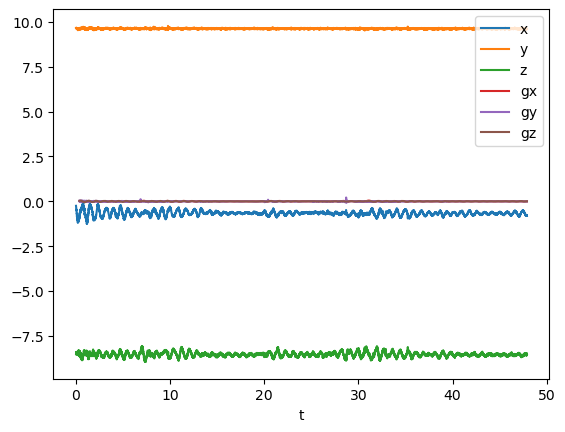

In [70]:
mergedData.plot(x="t")

In [71]:
#Entfernen der Zeilen mit fehlenden Sensordaten
df = mergedData.dropna(ignore_index = True).copy()

Offensichtlich sind die Daten des Beschleunigungssensors mit einem systematischen Fehler behaftet. Zur Kalibrierung wird das Gerät auf eine waagerechte Fläche gelegt / gestellt, jeweils in diametraler Orientierung.

In [72]:
# Korrektur / Kalibrierung des Accelerometers z Achse

# Ermittelte Werte des Beschleunigungssensors:
# Sensor aufrecht liegend: 
z_plus = 1.65
# Sensor umgekehrt liegend:
z_minus = -18.08

# lineare Umrechnung z_korr = a z + b
g = 9.81
a = 2*g/(z_plus - z_minus)
b = - g * (z_minus + z_plus)/(z_plus - z_minus)

zk = a * df.z  + b

df['zk'] = zk
# df['zk'] = df.apply(lambda row: a * row.z + b, axis = 1)

<Axes: xlabel='t'>

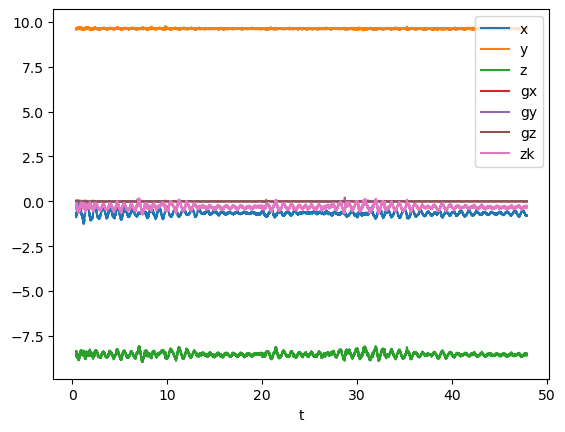

In [73]:
df.plot(x="t")

In [74]:
# Einlesen von Daten aus der Simulation
#data_dir = working_dir 
#os.chdir(data_dir)
#new_dir = os.getcwd()
#testdata = pd.read_csv("pendulum_data.csv") 
#print(testdata.head())
#df = testdata.rename(columns={"time":"t", "theta_noisy":"tn", "theta":"tx", "theta_dot":"txd"})
#print(df.head())

#df.plot("t","tx", grid=True, xlabel = "t [s]", ylabel = "theta_x [rad]", title="Zeitreihe Neigung")
#df.plot("t","txd", grid=True, xlabel = "t [s]", ylabel = "theta_x_dot [rad]")

Die Abtastrate des Smartphone-Sensors kann nicht festgelegt werden und muss aus den Messdaten ermittelt werden.

In [75]:
# Abtastintervall
dt = df.t[1] - df.t[0]
fs = 1/dt
print(fs)

198.59395480001498


An dieser Stelle soll einmal ein Periodogramm der Messgrößen dargestellt werden. Offensichtlich hat das System gedämpfte Resonanzen im Bereich von 1 Hz.

In [76]:
f, PXX = signal.periodogram(df.gx, fs)
#f, PYY = signal.periodogram(df.ty, fs)
#f, PZZ = signal.periodogram(df.tz, fs)

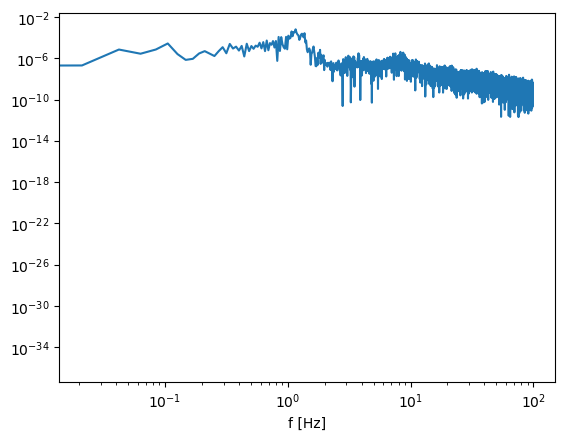

In [77]:
plt.figure()
plt.loglog(f, PXX)
#plt.loglog(f, PYY)
#plt.loglog(f, PZZ)
plt.xlabel("f [Hz]")
plt.show()

Definition von Funktionen für die Kalman Filterung 

In [78]:
X = np.array([0.0]) # Zustand: Auslenkung 
A = np.array([[1.0]]) # Übergangsmatrix 
H = np.array([[1.0]]) # Messung der Auslenkung -> vor dem Einsetzen von Y aus dem Drehwinkel berechnen berechnen
R = np.array([[1.0]])*5
P = np.array([[1.0]])
Q = np.array([[0.1]])
U = 0 # Eingangsgröße Drehwinkelrate (Anfangswert)
B = np.array([dt])

In [79]:
def kf_predict(X, P, A, Q, B, U):
    X = np.dot(A, X) + np.dot(B, U)
    P = np.dot(A, np.dot(P, A.T)) + Q
    return(X,P)

In [80]:
def kf_update(X, P, Y, H, R):
    IM = np.dot(H, X)
    IS = R + np.dot(H, np.dot(P, H.T))
    K = np.dot(P, np.dot(H.T, np.linalg.inv(IS)))
    X = X + np.dot(K, (Y-IM))
    P = P - np.dot(K, np.dot(IS, K.T))
    LH = gauss_pdf(Y, IM, IS)
    return (X,P,K,IM,IS,LH)

In [81]:
def gauss_pdf(X, M, S):
    if np.shape(M)[0] == 1:
        DX = X - np.tile(M, np.shape(X)[1])
        E = 0.5 * np.sum(DX * (np.dot(np.linalg.inv(S), DX)), axis=0)
        E = E + 0.5 * np.shape(M)[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    elif np.shape(X)[0] == 1:
        DX = np.tile(X, M.shape()[1])- M
        E = 0.5 * np.sum(DX * (np.dot(np.linalg.inv(S), DX)), axis=0)
        E = E + 0.5 * np.shape(M)[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    else:
        DX = X-M
        E = 0.5 * np.dot(DX.T, np.dot(np.linalg.inv(S), DX))
        E = E + 0.5 * np.shape(M)[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    return (P[0],E[0])

In [82]:
# Zeitreihen aus der Simulation
#thx = df.tn
#thxd = df.txd
#t = df.t

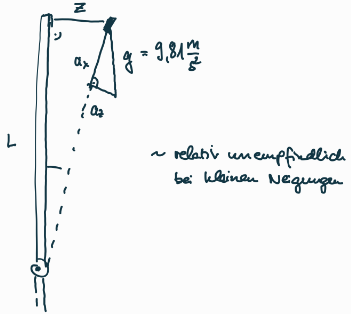

Die Neigung des Sensors läßt sich aus dem statischen Anteil der Beschleunigung berechnen. Da die Änderung der Neigung nur gering ist (kleine Winkel). 

In [83]:
# Zeitreihen aus der Messung
thx = df.zk/df.y # Näherungsweise: Drehwinkel als Verhältnis der Beschleunigungswerte
thxd = df.gx # Drehrate vom Gyroskop
t = df.t

In [84]:
n = 0
thx_e = np.zeros_like(thx)
kalman_gain = np.zeros_like(thx)

In [85]:
# Iterieren über die Zeitreihe
while n < len(thx):
    U = np.array([[thxd[n]]])
    (X, P) = kf_predict(X, P, A, Q, B, U)
    Y = np.array([[thx[n]]])
    (X, P, K, IM, IS, LH) = kf_update(X, P, Y, H, R)
    thx_e[n] = np.ndarray.item(X, 0)
    kalman_gain[n] = np.ndarray.item(K, 0)
    n += 1 

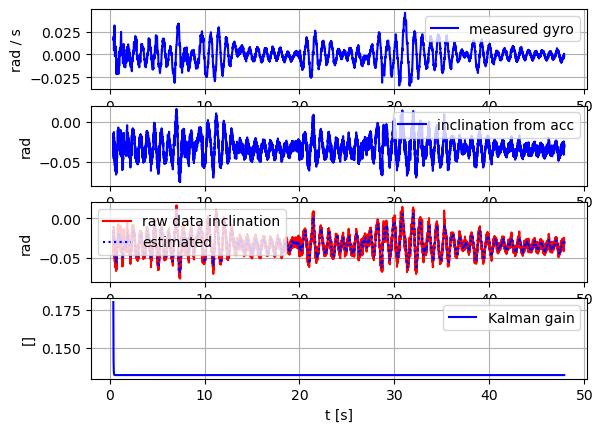

In [86]:
plt.figure()

plt.subplot(4,1,1)
plt.plot(t, thxd, 'b', label = "measured gyro")
plt.xlabel("t [s]")
plt.ylabel("rad / s")
plt.grid()
plt.legend()
#

plt.subplot(4,1,2)
plt.plot(t, thx, 'b', label = "inclination from acc")
plt.xlabel("t [s]")
plt.ylabel("rad")
plt.grid()
plt.legend()

plt.subplot(4,1,3)
plt.plot(t, thx, 'r', label = "raw data inclination")
plt.plot(t, thx_e, 'b:', label = "estimated")
# plt.plot(t, df.tx, 'k--', label = 'ground truth') # nur für die Simulation
plt.xlabel("t [s]")
plt.ylabel("rad")
plt.grid()
plt.legend()

plt.subplot(4,1,4)
plt.plot(t, kalman_gain, 'b', label = "Kalman gain")
plt.xlabel("t [s]")
plt.ylabel("[]")
plt.grid()
plt.legend()


plt.show()

In [87]:
# Auslenkung aus der Inklination des Sensors
l = 1
z = thx_e*l

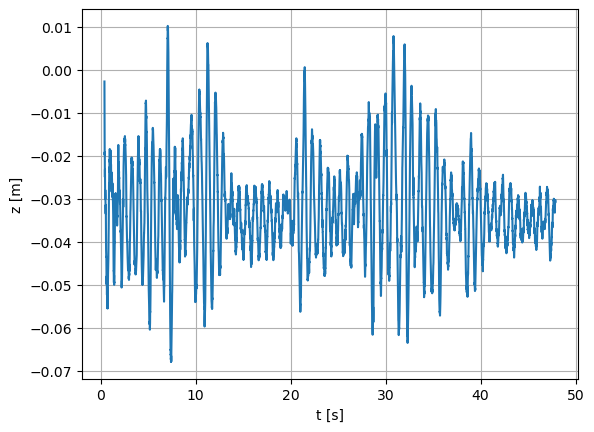

In [88]:
plt.figure()
plt.plot(t, z)
plt.xlabel('t [s]')
plt.ylabel('z [m]')
plt.grid()
plt.show()

In [96]:
t_var1 = t
z_var1 = z

In [97]:
f, PXX = signal.periodogram(z, fs)
#f, PYY = signal.periodogram(df.ty, fs)
#f, PZZ = signal.periodogram(df.tz, fs)

### Zum Vergleich: Integration der Drehrate

In [98]:
thx_i = np.zeros_like(thxd)

In [92]:
for n in range(len(thxd)-1):
    thx_i[n+1] = thx_i[n] + dt * thx[n]

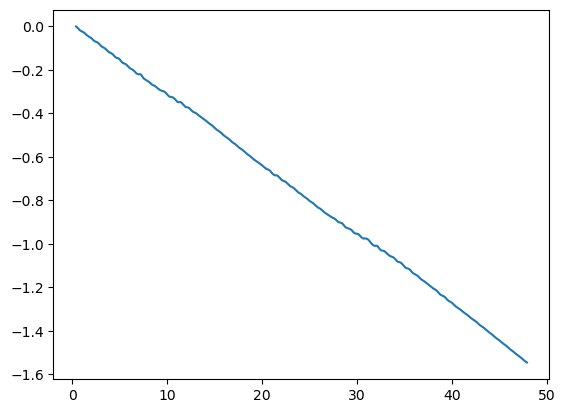

In [93]:
plt.figure()
plt.plot(t,thx_i)

### Vergleichsfall mit zweitem Datensatz

In [94]:
# Einlesen der Messdaten
working_dir = "/Users/dirkm/Documents/Github/python_experiments"
os.chdir(working_dir)
new_dir = os.getcwd()
#
print("New current working directory:", new_dir)
#experiment_dir = "2024-08-10_16-01-40"
#experiment_dir = "2024-08-10_19-22-24"
#experiment_dir = "2024-08-10_20-04-53"
#experiment_dir = "2024-09-01_14-10-02" # nach Anbringung einer Versteifung am "Gelenk"
experiment_dir = "2024-09-01_14-00-40" # vor Anbringung einer Versteifung am "Gelenk"

#data_dir = working_dir + "/Beschleunigung ohne g " + experiment_dir
data_dir = working_dir + "/My Experiment " + experiment_dir
os.chdir(data_dir)
new_dir = os.getcwd()
print("New current working directory:", new_dir)
#testdata = pd.read_csv("Raw data.csv") 
# Einlesen der Beschleunigungsdaten
testdata = pd.read_csv("Accelerometer.csv") 
print(testdata.head())
#df1 = testdata.rename(columns={"Time (s)": "t", "Linear Acceleration x (m/s^2)" : "x", "Linear Acceleration y (m/s^2)" : "y", "Linear Acceleration z (m/s^2)" : "z" })
df1 = testdata.rename(columns={"Time (s)": "t", "Acceleration x (m/s^2)" : "x", "Acceleration y (m/s^2)" : "y", "Acceleration z (m/s^2)" : "z" })
#Einlesen der Gyroskopdaten
testdata = pd.read_csv("Gyroscope.csv") 
print(testdata.head())
df2 = testdata.rename(columns={"Time (s)": "t", "Gyroscope x (rad/s)" : "gx", "Gyroscope y (rad/s)" : "gy", "Gyroscope z (rad/s)" : "gz" })

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: '/Users/dirkm/Documents/Github/python_experiments'

In [32]:
# Zusammenfassen in 1 Pandas Data Frame
mergedData = pd.merge_asof(df1, df2, on='t', direction='backward')

In [33]:
#Entfernen der Zeilen mit fehlenden Sensordaten
df = mergedData.dropna(ignore_index = True).copy()

In [34]:
# Korrektur / Kalibrierung des Accelerometers z Achse
# Sensor aufrecht liegend: 
z_plus = 1.65
# Sensor umgekehrt liegend:
z_minus = -18.08

# lineare Umrechnung z_korr = a z + b
g = 9.81
a = 2*g/(z_plus - z_minus)
b = - g * (z_minus + z_plus)/(z_plus - z_minus)

zk = a * df.z  + b

df['zk'] = zk
# df['zk'] = df.apply(lambda row: a * row.z + b, axis = 1)

In [35]:
# Abtastintervall
dt = df.t[1] - df.t[0]
fs = 1/dt
print(fs)

198.59395480001717


In [36]:
# Zeitreihen aus der Messung
thx = df.zk/df.y # Näherungsweise: Drehwinkel als Verhältnis der Beschleunigungswerte
thxd = df.gx # Drehrate vom Gyroskop
t = df.t

In [37]:
n = 0
thx_e = np.zeros_like(thx)
kalman_gain = np.zeros_like(thx)

In [38]:
# Iterieren über die Zeitreihe
while n < len(thx):
    U = np.array([[thxd[n]]])
    (X, P) = kf_predict(X, P, A, Q, B, U)
    Y = np.array([[thx[n]]])
    (X, P, K, IM, IS, LH) = kf_update(X, P, Y, H, R)
    thx_e[n] = np.ndarray.item(X, 0)
    kalman_gain[n] = np.ndarray.item(K, 0)
    n += 1 

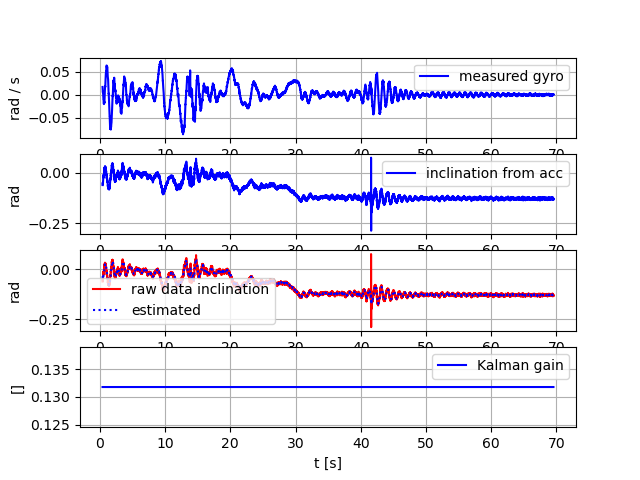

In [39]:
plt.figure()

plt.subplot(4,1,1)
plt.plot(t, thxd, 'b', label = "measured gyro")
plt.xlabel("t [s]")
plt.ylabel("rad / s")
plt.grid()
plt.legend()
#

plt.subplot(4,1,2)
plt.plot(t, thx, 'b', label = "inclination from acc")
plt.xlabel("t [s]")
plt.ylabel("rad")
plt.grid()
plt.legend()

plt.subplot(4,1,3)
plt.plot(t, thx, 'r', label = "raw data inclination")
plt.plot(t, thx_e, 'b:', label = "estimated")
# plt.plot(t, df.tx, 'k--', label = 'ground truth') # nur für die Simulation
plt.xlabel("t [s]")
plt.ylabel("rad")
plt.grid()
plt.legend()

plt.subplot(4,1,4)
plt.plot(t, kalman_gain, 'b', label = "Kalman gain")
plt.xlabel("t [s]")
plt.ylabel("[]")
plt.grid()
plt.legend()


plt.show()

In [40]:
# Auslenkung aus der Inklination des Sensors
l = 1
z = thx_e*l

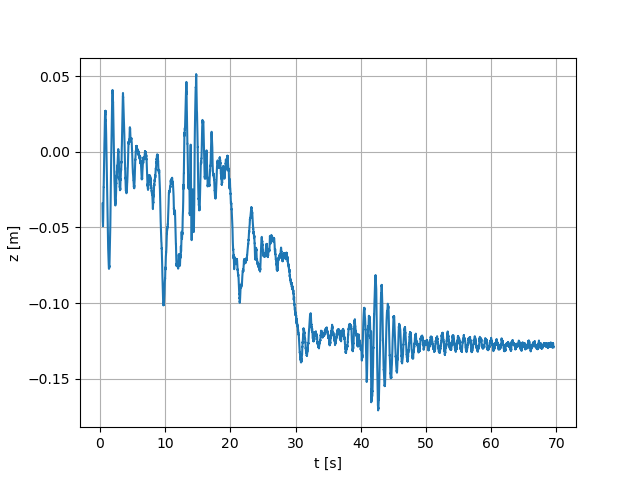

In [41]:
plt.figure()
plt.plot(t, z)
plt.xlabel('t [s]')
plt.ylabel('z [m]')
plt.grid()
plt.show()

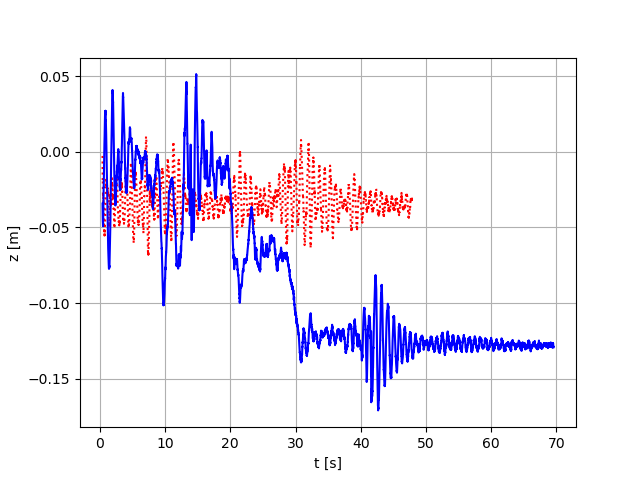

In [42]:
plt.figure()
plt.plot(t_var1,z_var1,'r:')
plt.plot(t,z,'b')
plt.xlabel('t [s]')
plt.ylabel('z [m]')
plt.grid()
plt.show()